### Loading and examining data

In [57]:
import scipy.constants
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import resample



import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.base import clone

In [121]:
df = pd.read_csv('merged_data_sub_10.csv')
df.shape # before cleaning

(4262, 58)

In [122]:
thresh = len(df) * 0.05 # drop column if missing values in more than 95% of rows
df = df.dropna(thresh=thresh, axis = 1)
thresh2 = 20 # drop rows with < 20 non-missing
df = df.dropna(thresh=thresh2, axis=0)

In [123]:
df.shape

(4262, 58)

In [124]:
print(df.columns)

Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'SDMVPSU',
       'SDMVSTRA', 'WTMEC4YR', 'SDDSRVYR', 'RIDSTATR', 'LBXSAL', 'LBDSALSI',
       'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA',
       'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
       'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI',
       'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI',
       'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI',
       'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH',
       'LBDLHSI', 'SSCYPC', 'WTSCY4YR', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys', 'simulated_mGFR'],
      dtype='object')


In [125]:
# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR"] # "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape)
print(X_labeled.columns)

(426, 51) (426,) (3836, 51)
Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'LBXSAL',
       'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI',
       'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI',
       'LBXSGL', 'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH',
       'LBDSPHSI', 'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR',
       'LBDSTRSI', 'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI',
       'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI',
       'LBXLH', 'LBDLHSI', 'SSCYPC', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys'],
      dtype='object')


## Self training: run through with plots

Trains regressor on labeled data, then predicts on unlabeled data. Adds "confident" predictions from unlabeled data to the labeled dataset. Repeat iteratively for defined number of iterations or until no further predictions are found. Plots
1) distribution of residuals
2) extreme residuals vs. race and gender
3) feature importances
4) scatterplot of predicted vs. actual (simulated) mGFR

In [146]:
# y_labeled = y_labeled.to_numpy()
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
print(X_train_labeled.shape, X_test_labeled.shape)

(340, 51) (86, 51)


In [147]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
print("hi")

# XGBoost, grid search and 5 fold CV
xgb_regressor = xgb.XGBRegressor()
grid_search = RandomizedSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_labeled, y_train_labeled)

best_xgb_regressor = grid_search.best_estimator_

hi


In [150]:
# reference: https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/

n_models = 10 # for METHOD 3

def self_training_regressor(X_labeled, y_labeled, X_unlabeled, base_regressor, threshold=3, max_iter=10):
    model = clone(base_regressor)
    # ensemble = [clone(base_regressor) for _ in range(n_models)] # for METHOD 3

    for iteration in range(max_iter):
        
        # # METHOD 3: ensembling
        # for model in ensemble:
        #     model.fit(X_labeled, y_labeled)
        #     # Collect predictions from each model in the ensemble
        # ensemble_predictions = np.array([model.predict(X_unlabeled) for model in ensemble])
        
        # # Calculate the mean prediction and the standard deviation (uncertainty)
        # y_unlabeled_pred = np.mean(ensemble_predictions, axis=0)
        # uncertainty = np.std(ensemble_predictions, axis=0)


        # Train the model (best_xbg_regression) on the labeled data
        model.fit(X_labeled, y_labeled)
        
        # Predict on the unlabeled data
        y_unlabeled_pred = model.predict(X_unlabeled)
        
        # METHOD 1: naively get unlabeled predictions past a certain threshold/confidence to the labeled data 
        # for regression, closest to mean prediction?
        # confidence = np.abs(y_unlabeled_pred - np.mean(y_labeled)) / np.std(y_labeled)
        # confident_indices = np.where(confidence <= threshold)[0]

        # METHOD 2: estimate variability in predictions using bootstrapping, then get predictions with low uncertainty 
        bootstrapped_predictions = []
        for _ in range(10):  # Bootstrap 10 samples
            X_boot, y_boot = resample(X_labeled, y_labeled)
            model.fit(X_boot, y_boot)
            bootstrapped_predictions.append(model.predict(X_unlabeled))
        
        uncertainty = np.std(bootstrapped_predictions, axis=0) # uncertainty for each prediction
        print(uncertainty)
        
        confident_indices = np.where(uncertainty <= threshold)[0] # could decrease this threshold iteratively? 
        
        if len(confident_indices) == 0:
            print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
            break
        
        # add the confident predictions to the labeled dataset
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[confident_indices]], ignore_index=True)
        y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
        
        # remove those same confident predictions from the unlabeled dataset
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices]).reset_index(drop=True)
        
        print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
    
    print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
    return model

# Apply self-training
print("X_train_labeled shape: ", X_train_labeled.shape)
print("y_train_labeled shape: ", y_train_labeled.shape)
print("X_unlabeled shape: ", X_unlabeled.shape)
print("X_test_labeled shape: ", X_test_labeled.shape)
final_model = self_training_regressor(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor)


X_train_labeled shape:  (340, 51)
y_train_labeled shape:  (340,)
X_unlabeled shape:  (3836, 51)
X_test_labeled shape:  (86, 51)
[5.6111355 4.510119  5.227022  ... 4.4614406 2.066085  5.8698244]
Iteration 1: Added 469 confident predictions to the labeled dataset.
[4.770541  2.821563  3.6298943 ... 2.1180184 1.7811493 4.9095674]
Iteration 2: Added 1892 confident predictions to the labeled dataset.
[1.8446308 2.0554557 3.6794996 ... 2.1223745 2.898452  4.4972725]
Iteration 3: Added 868 confident predictions to the labeled dataset.
[3.5241146  4.4069314  6.5882     3.5205026  3.3724234  2.198986
 3.149147   4.236413   4.045568   4.611252   2.7106957  3.6511626
 3.666909   6.696144   3.3483636  6.5550165  5.6070743  5.6824574
 2.0373747  7.5351214  4.9781094  0.93238795 6.6374803  3.655513
 3.546075   4.4185653  5.83493    4.7030396  0.8732888  1.8109099
 3.0555398  6.010678   5.2663136  5.136025   4.1955104  3.2120821
 2.349845   5.4633384  2.681759   2.6719959  1.9910733  4.089342
 1.4844

In [151]:
# Evaluate on the validation set
y_val_pred = final_model.predict(X_test_labeled)
mse = mean_squared_error(y_test_labeled, y_val_pred)
print(f'Mean Squared Error on validation set: {mse}')

Mean Squared Error on validation set: 247.99518982060874


In [153]:
# Predict on the test set
y_pred = final_model.predict(X_test_labeled)
# Evaluate the model
r2 = r2_score(y_test_labeled, y_pred)
mae = mean_absolute_error(y_test_labeled, y_pred)

print(f'R-squared: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

R-squared: 0.6625
Mean Absolute Error: 12.6853


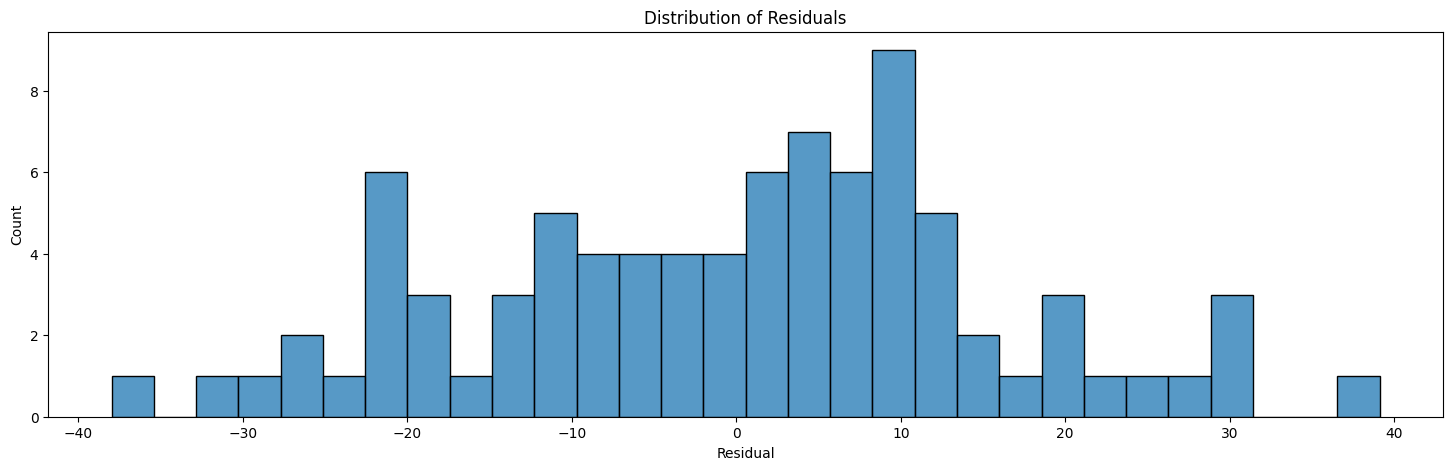

In [154]:
# Plotting residuals
xgb_preds = final_model.predict(X_test_labeled)
actuals = y_test_labeled
resids = xgb_preds - actuals

plt.figure(figsize=(18, 5))
sns.histplot(resids, bins=30, kde=False)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

4149     51.581779
786      73.037279
1763     59.082823
340     108.415005
3501     34.484637
           ...    
3769     95.575704
585      60.371753
1334     92.841574
232      38.049026
173      83.964307
Name: simulated_mGFR, Length: 86, dtype: float64


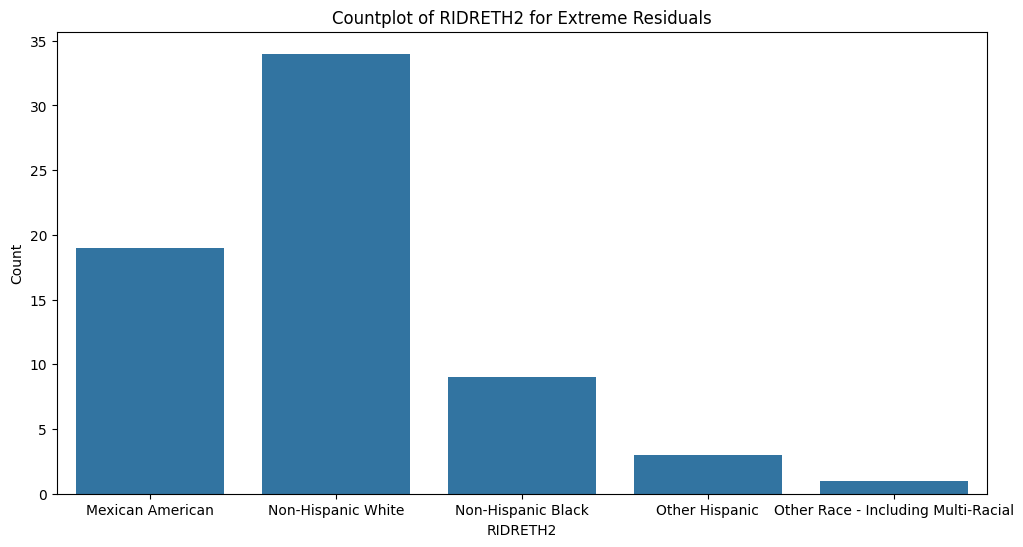

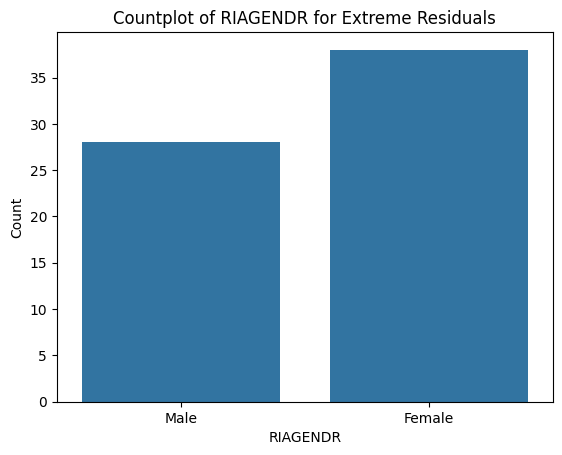

In [155]:
# turn y_test into Pandas series so can index
y_test_series = pd.Series(y_test_labeled)
print(y_test_series)

# Convert residuals to a pandas Series with the same index
resids_series = pd.Series(resids, index=y_test_series.index)
# print(resids_series)

# Filter the indices where residuals are less than -5 or greater than 5 
filtered_indices = resids_series[(resids_series < -5) | (resids_series > 5)].index
df['RIDRETH2_decoded'] = label_encoders['RIDRETH2'].inverse_transform(df['RIDRETH2'])
df['RIAGENDR_decoded'] = label_encoders['RIAGENDR'].inverse_transform(df['RIAGENDR'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df.loc[filtered_indices], x='RIDRETH2_decoded')
plt.title('Countplot of RIDRETH2 for Extreme Residuals')
plt.xlabel('RIDRETH2')
plt.ylabel('Count')
plt.show()

sns.countplot(data=df.loc[filtered_indices], x='RIAGENDR_decoded')
plt.title('Countplot of RIAGENDR for Extreme Residuals')
plt.xlabel('RIAGENDR')
plt.ylabel('Count')
plt.show()


/var/folders/6p/6161x96942x8rv20mn8nby2r0000gn/T/ipykernel_90564/3458075820.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

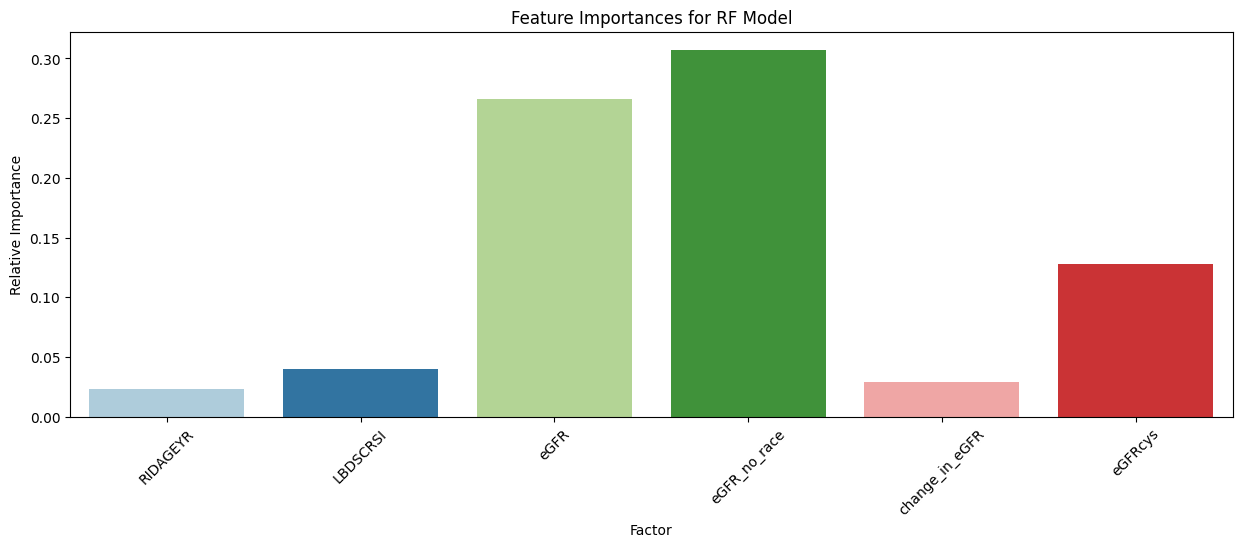

In [157]:
varimp = []
for name, score in zip(X_labeled.columns, final_model.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');
plt.xticks(rotation=45)

In [158]:
varimps.sort_values(by = 'Relative Importance', ascending=False)


,Factor,Relative Importance
3,eGFR_no_race,0.307021
2,eGFR,0.266140
5,eGFRcys,0.127951
1,LBDSCRSI,0.039867
4,change_in_eGFR,0.029439
0,RIDAGEYR,0.023366


Text(0, 0.5, 'Actual Values')

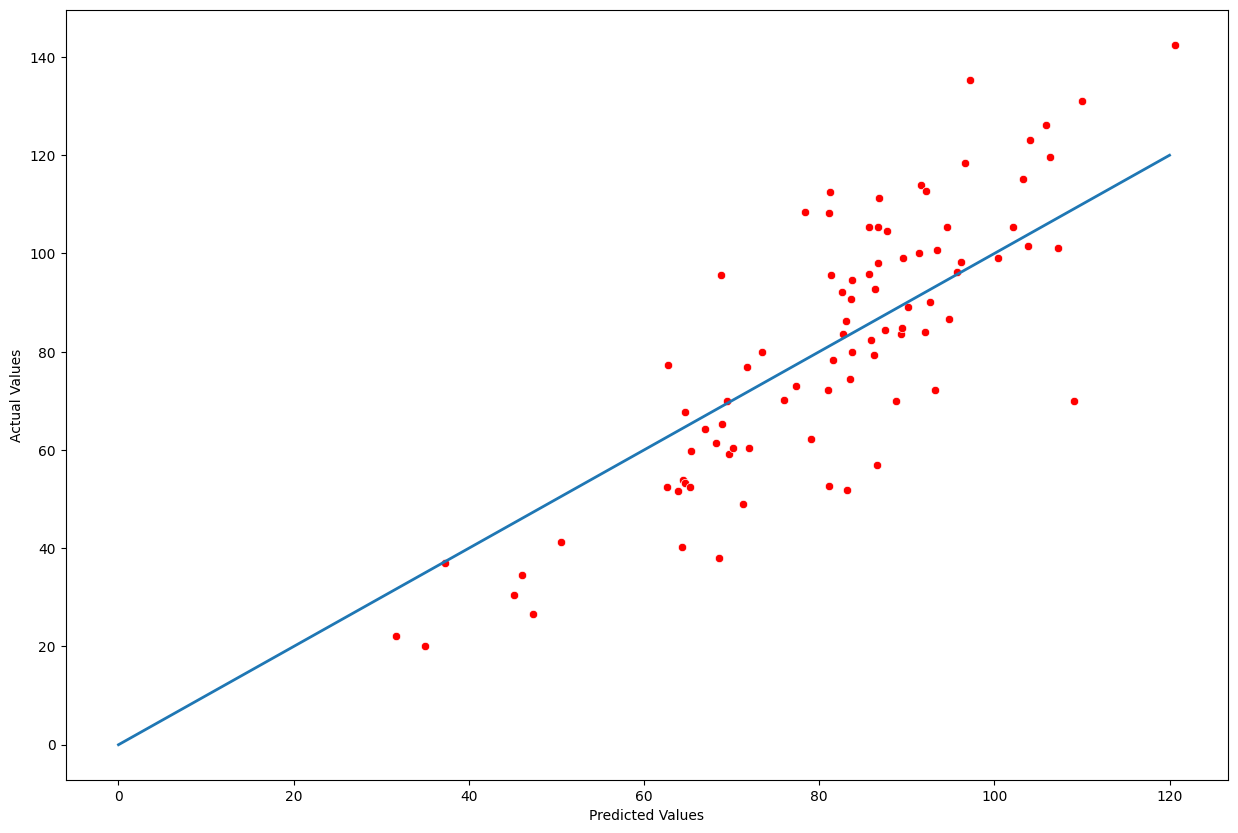

In [159]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=final_model.predict(X_test_labeled), y=y_test_labeled, color="red");
plt.plot([0, 120], [0, 120], linewidth=2);
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

### Effect of varying threshold: 2 methods. 

Plots MAE and R2 as a function of confidence threshold. 


Threshold: 1.0
[4.165652  2.839251  3.9309292 ... 2.625442  3.3286772 2.5161214]
Iteration 1: Added 2 confident predictions to the labeled dataset.
[4.413482  2.6962233 4.0208106 ... 2.867738  2.6743338 5.51877  ]
Size of final labeled dataset:  342  (total is 4262 samples, 4176 training)
Size of final labeled dataset:  342  (total is 4262 samples, 4176 training)
r2, mae:  0.6334150312759883 13.347262061711966
Threshold: 2.25
[4.1697946 4.210512  3.73968   ... 3.3461823 2.833922  3.6007888]
Iteration 1: Added 483 confident predictions to the labeled dataset.
[4.0437775 3.2421067 4.264742  ... 1.0494039 0.7622179 6.8996353]
Iteration 2: Added 1711 confident predictions to the labeled dataset.
[1.2541125 1.0395857 1.1700575 ... 5.3599186 1.8590703 4.7983484]
Iteration 3: Added 909 confident predictions to the labeled dataset.
[1.8372464  3.945787   6.7034545  4.820243   2.643285   1.7782234
 3.1713178  3.8676922  3.8879182  3.2729466  6.5520387  2.0861573
 3.542213   3.831557   4.517018 

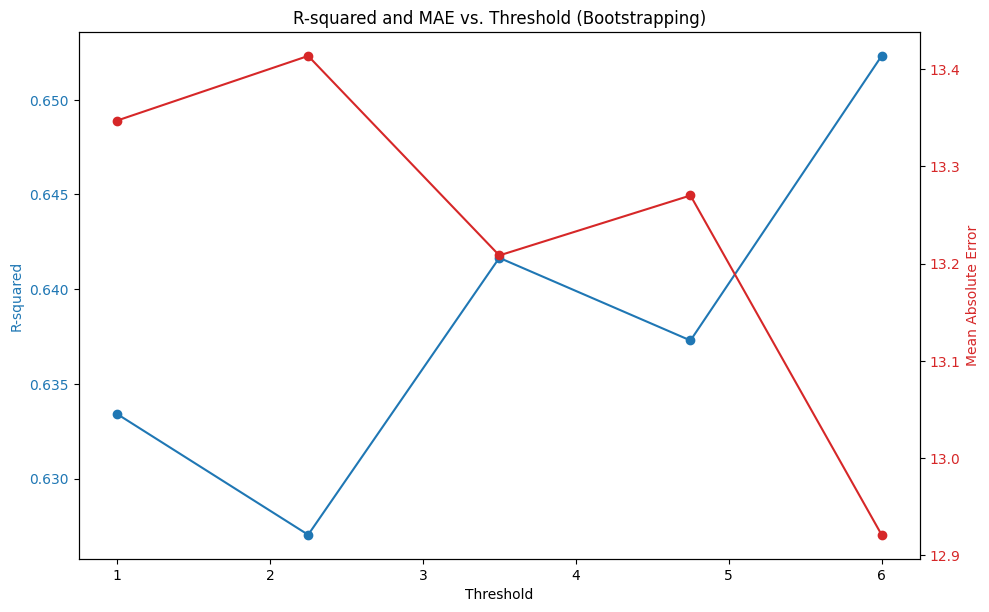

[3.4891984 2.5527878 2.2027993 ... 2.3331861 1.9991633 4.966504 ]
Iteration 1: Added 3698 confident predictions to the labeled dataset.
[1.2284088  0.7577786  1.3355478  0.7162709  1.1280545  1.0076338
 0.6781846  0.37406114 0.4865575  0.37229687 0.37493116 0.512237
 0.7556422  0.71321744 0.85902077 0.32751706 1.7099402  0.8111728
 0.93160653 0.4738686  0.44052693 0.855332   0.59654087 0.9877202
 0.7218773  1.4463909  0.48064458 0.41696474 0.7374878  0.5895746
 0.39696473 1.0153137  1.6101226  0.43249243 0.8209134  0.5334225
 0.39422104 0.64985293 0.3462978  1.1402158  1.2111504  2.1650937
 0.5558864  0.58230394 0.5373314  0.41837978 0.4502842  1.0381224
 0.6912241  0.62212497 0.4158086  0.64478755 0.52840763 0.47529262
 0.67162067 0.73931634 0.4239313  0.7292143  1.3215966  0.59040064
 0.5855159  0.5935125  1.0367385  1.4358857  0.6274151  1.1466429
 0.9862474  1.6507832  1.7663549  1.6347406  0.86397547 0.3883435
 1.1920125  0.4711729  0.72551805 0.5534462  1.163382   1.0415119
 0.64

In [145]:
# Bootstrapping
def self_training_regressor_bootstrapping(X_labeled, y_labeled, X_unlabeled, base_regressor, threshold=1e-5, max_iter=10):
    model = clone(base_regressor)
    for iteration in range(max_iter):
        # Train the model (best_xbg_regression) on the labeled data
        model.fit(X_labeled, y_labeled)
        
        # Predict on the unlabeled data
        y_unlabeled_pred = model.predict(X_unlabeled)
        
        # Estimate variability in predictions using bootstrapping, then get predictions with low uncertainty 
        bootstrapped_predictions = []
        for _ in range(10):  # Bootstrap 10 samples
            X_boot, y_boot = resample(X_labeled, y_labeled)
            model.fit(X_boot, y_boot)
            bootstrapped_predictions.append(model.predict(X_unlabeled))
        
        uncertainty = np.std(bootstrapped_predictions, axis=0) # uncertainty for each prediction
        print(uncertainty)
        
        confident_indices = np.where(uncertainty <= threshold)[0] # could decrease this threshold iteratively? 
        
        
        if len(confident_indices) == 0:
            print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
            break
        
        # Add the confident predictions to the labeled dataset
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[confident_indices]], ignore_index=True)
        y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
        
        # Remove those same confident predictions from the unlabeled dataset
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices]).reset_index(drop=True)
        
        print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
    
    print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return r2, mae

# Apply self-training for different threshold values
thresholds = np.linspace(1, 6, 5)  
r2_scores = []
mae_scores = []

for threshold in thresholds:
    print(f'Threshold: {threshold}')
    final_model = self_training_regressor_bootstrapping(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor, threshold=threshold)
    r2, mae = evaluate_model(final_model, X_test_labeled, y_test_labeled)
    print("r2, mae: ", r2, mae)
    r2_scores.append(r2)
    mae_scores.append(mae)

# Plot the results with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('R-squared', color=color)
ax1.plot(thresholds, r2_scores, label='R-squared', color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mean Absolute Error', color=color)  # we already handled the x-label with ax1
ax2.plot(thresholds, mae_scores, label='Mean Absolute Error', color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('R-squared and MAE vs. Threshold (Bootstrapping)')
plt.grid(False)
plt.show()

# Evaluate the model with the final chosen threshold
final_threshold = thresholds[np.argmax(r2_scores)]  # Or choose based on another criterion
final_model = self_training_regressor_bootstrapping(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor, threshold=final_threshold)
y_pred = final_model.predict(X_test_labeled)
r2 = r2_score(y_test_labeled, y_pred)
mae = mean_absolute_error(y_test_labeled, y_pred)

print(f'Final threshold: {final_threshold:.4f}')
print(f'Final R-squared: {r2:.4f}')
print(f'Final Mean Absolute Error: {mae:.4f}')

Threshold: 1e-06
Iteration 1: Added 1479 confident predictions to the labeled dataset.
Iteration 2: Added 879 confident predictions to the labeled dataset.
Iteration 3: Added 549 confident predictions to the labeled dataset.
Iteration 4: Added 345 confident predictions to the labeled dataset.
Iteration 5: Added 223 confident predictions to the labeled dataset.
Iteration 6: Added 129 confident predictions to the labeled dataset.
Iteration 7: Added 107 confident predictions to the labeled dataset.
Iteration 8: Added 39 confident predictions to the labeled dataset.
Iteration 9: Added 33 confident predictions to the labeled dataset.
Iteration 10: Added 23 confident predictions to the labeled dataset.
Size of final labeled dataset:  4146  (total is 4262 samples, 4176 training)
r2, mae:  0.6310417825333201 13.398633557041878
Threshold: 2.5750000000000002e-05
Iteration 1: Added 3836 confident predictions to the labeled dataset.
Size of final labeled dataset:  4176  (total is 4262 samples, 417

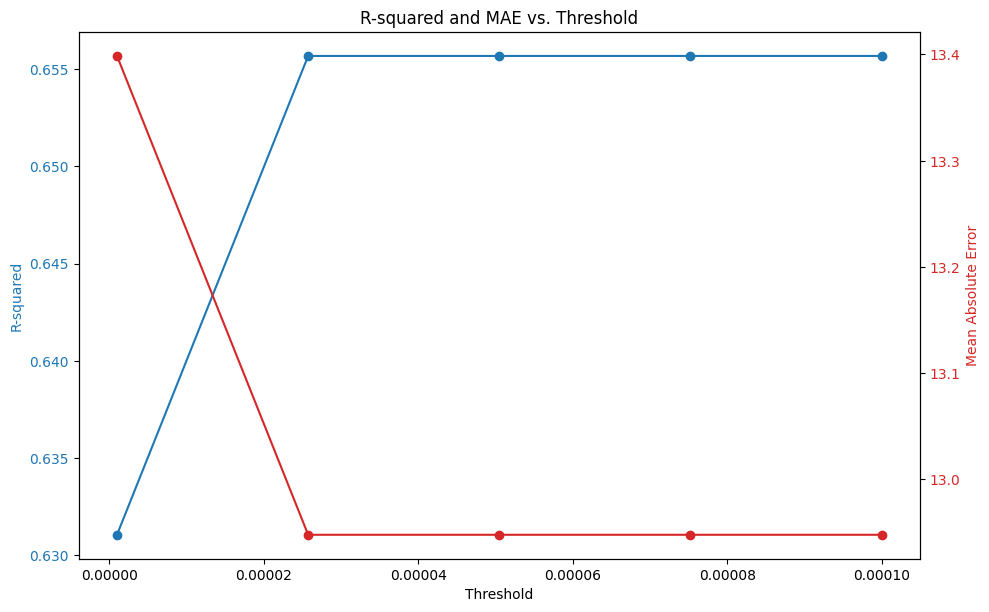

Iteration 1: Added 3836 confident predictions to the labeled dataset.
Size of final labeled dataset:  4176  (total is 4262 samples, 4176 training)
Size of final labeled dataset:  4176  (total is 4262 samples, 4176 training)
Final threshold: 0.000025750
Final R-squared: 0.6557
Final Mean Absolute Error: 12.9478


In [144]:
# Ensembling
n_models = 10  # for ensembling

def self_training_regressor(X_labeled, y_labeled, X_unlabeled, base_regressor, threshold=1e-5, max_iter=10):
    ensemble = [clone(base_regressor) for _ in range(n_models)]  # for ensembling

    for iteration in range(max_iter):
        # Train each model in the ensemble on the labeled data
        for model in ensemble:
            model.fit(X_labeled, y_labeled)
        
        # Collect predictions from each model in the ensemble
        ensemble_predictions = np.array([model.predict(X_unlabeled) for model in ensemble])
        
        # Calculate the mean prediction and the standard deviation (uncertainty)
        y_unlabeled_pred = np.mean(ensemble_predictions, axis=0)
        uncertainty = np.std(ensemble_predictions, axis=0)

        confident_indices = np.where(uncertainty <= threshold)[0]
        
        if len(confident_indices) == 0:
            print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
            break
        
        # add the confident predictions to the labeled dataset
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[confident_indices]], ignore_index=True)
        y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
        
        # remove those same confident predictions from the unlabeled dataset
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices]).reset_index(drop=True)
        
        print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
    
    print("Size of final labeled dataset: ", len(y_labeled), " (total is 4262 samples, 4176 training)") 
    return ensemble

def evaluate_model(models, X_test, y_test):
    ensemble_predictions = np.array([model.predict(X_test) for model in models])
    y_pred = np.mean(ensemble_predictions, axis=0)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return r2, mae

# Apply self-training for different threshold values
thresholds = np.linspace(1e-6, 1e-4, 5)  
r2_scores = []
mae_scores = []

for threshold in thresholds:
    print(f'Threshold: {threshold}')
    final_models = self_training_regressor(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor, threshold=threshold)
    r2, mae = evaluate_model(final_models, X_test_labeled, y_test_labeled)
    print("r2, mae: ", r2, mae)
    r2_scores.append(r2)
    mae_scores.append(mae)

# Plot the results with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('R-squared', color=color)
ax1.plot(thresholds, r2_scores, label='R-squared', color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mean Absolute Error', color=color)  # we already handled the x-label with ax1
ax2.plot(thresholds, mae_scores, label='Mean Absolute Error', color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('R-squared and MAE vs. Threshold')
plt.grid(False)
plt.show()

# Evaluate the model with the final chosen threshold
final_threshold = thresholds[np.argmax(r2_scores)]  # Or choose based on another criterion
final_models = self_training_regressor(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor, threshold=final_threshold)
y_pred = np.mean([model.predict(X_test_labeled) for model in final_models], axis=0)
r2 = r2_score(y_test_labeled, y_pred)
mae = mean_absolute_error(y_test_labeled, y_pred)

print(f'Final threshold: {final_threshold:.9f}')
print(f'Final R-squared: {r2:.4f}')
print(f'Final Mean Absolute Error: {mae:.4f}')

## Co-training

In [ ]:
from mvlearn.semi_supervised import CTRegressor

